## Model ViT-B16

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import copy
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision import transforms

import time

start_time = time.time()

In [2]:
#!pip install torch torchvision torchaudio

# (Chú ý: Đảm bảo bạn đã cài đặt NVIDIA driver, nếu không bạn cần cài đặt nó trước)
import os
# Thêm biến môi trường CUDA_LAUNCH_BLOCKING=1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

cuda
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
num_classes = 12  # Replace with the number of classes in your dataset
batch_size = 32
learning_rate = 0.001

In [8]:
import torch
from torchvision import transforms, datasets

# Modify the dataset path to the correct location
dataset_path = "../../Smartbin/Dataset/Crawl_dataset/Data_real"  # Replace with the actual path

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize pixel values
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)

# Check if dataset is loaded successfully
if len(dataset) > 0:
    print(f"Dataset loaded successfully! Found {len(dataset)} images.")
else:
    print("Error: Dataset is empty. Please check the directory path and image formats.")

# Create data loader for training or testing
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Dataset loaded successfully! Found 19970 images.


In [9]:
#dataset = "../../Smartbin/Dataset/garbage_classification"
#dataset = "../../Smartbin/Dataset/dataset"
#dataset = "../../Smartbin/Dataset/trashify-image-dataset"
#dataset = "../../Smartbin/Dataset/Bag_Classes"
#dataset = "../../Smartbin/Dataset/Bag4Classes"
#dataset = "../../Smartbin/Dataset/waste_dataset"
#dataset = "../../Smartbin/Dataset/Garbage_classification_dataset"
#dataset = "../../Smartbin/Dataset/garbage_dataset"
#dataset = "../../Smartbin/Dataset/garbage_classification_3"
#dataset = "../../Smartbin/Dataset/garbage_classification_enhanced"
#dataset = "../../Smartbin/Dataset/Garbage_classification_2"
#dataset = "../../Smartbin/Dataset/garbage1_dataset"
#dataset = "../../Smartbin/Dataset/Drinking_waste_classification"
#dataset = "../../Smartbin/Dataset/dataset_capstone_9"
#dataset = "../../Smartbin/Dataset/TrashType_Image_Dataset"
#dataset = "../../Smartbin/Dataset/trash_dataset"
dataset = "../../Smartbin/Dataset/Crawl_dataset/Data_real"
datasets_data = datasets.ImageFolder(
    dataset,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [10]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import Subset
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset1 = {}

# train-validation split
train_idx, valtest_idx = train_test_split(list(range(len(datasets_data))),
                                          test_size=0.3,
                                          random_state=random_seed)

dataset1['train'] = Subset(datasets_data, train_idx)
valtest          = Subset(datasets_data, valtest_idx)


# validation-test split
val_idx, test_idx = train_test_split(list(range(len(valtest))),
                                     test_size=0.67,
                                     random_state=random_seed)

dataset1['valid'] = Subset(valtest, val_idx)
dataset1['test']  = Subset(valtest, test_idx)

max_trn_corrects = len(dataset1['train'])
max_val_corrects = len(dataset1['valid'])

In [11]:
dataloaders, batch_num = {}, {}

dataloaders['train'] = DataLoader(dataset1['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=12)
dataloaders['valid'] = DataLoader(dataset1['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=12)
dataloaders['test'] = DataLoader(dataset1['test'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=12)

batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])


print('batch_size : {}\ntrain/valid/test : {}/{}/{}'
      .format(batch_size,
              batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 32
train/valid/test : 437/62/126


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([3, 224, 224])


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


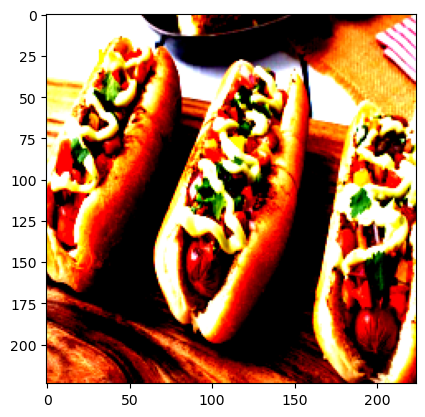

In [12]:
import matplotlib.pyplot as plt
import numpy as np
imgtest = None
for images, labels in dataloaders['train']:
    imgtest = images[3]
    print(imgtest.shape)
    break

imgtest = imgtest.numpy()
imgtest = np.moveaxis(imgtest, 0, -1)
plt.imshow(imgtest)

In [13]:
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

In [14]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs, patience):
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_accuracy'].append(epoch_acc)
            else:
                history['val_accuracy'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'valid':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(patience))
            break

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
# Sử dụng device
model = pretrained_vit
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.heads = nn.Linear(in_features=768, out_features=num_classes).to(device)
# Định nghĩa các tham số cần thiết như model, criterion, optimizer, dataloaders, và num_epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 200
patience = 50
# Huấn luyện model
start_time = time.time()
model_trained = train_model(model, criterion, optimizer, dataloaders, num_epochs,patience)
end_time = time.time()
execution_time = end_time - start_time
print("Thời gian huấn luyện model là:", execution_time, "s")

Epoch 1/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.2040 Acc: 0.9650


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0636 Acc: 0.9848
Epoch 2/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0465 Acc: 0.9885


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0498 Acc: 0.9858
Epoch 3/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0338 Acc: 0.9907


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0460 Acc: 0.9874
Epoch 4/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0272 Acc: 0.9926


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0435 Acc: 0.9879
Epoch 5/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0222 Acc: 0.9944


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0430 Acc: 0.9884
Epoch 6/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0191 Acc: 0.9950


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0421 Acc: 0.9874
Epoch 7/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0169 Acc: 0.9959


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

valid Loss: 0.0430 Acc: 0.9874
Epoch 8/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0147 Acc: 0.9966


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0433 Acc: 0.9874
Epoch 9/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0132 Acc: 0.9965


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0442 Acc: 0.9889
Epoch 10/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0114 Acc: 0.9976


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

valid Loss: 0.0424 Acc: 0.9889
Epoch 11/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0101 Acc: 0.9977


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0458 Acc: 0.9879
Epoch 12/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0093 Acc: 0.9981


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0462 Acc: 0.9879
Epoch 13/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0082 Acc: 0.9984


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0477 Acc: 0.9874
Epoch 14/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0074 Acc: 0.9988


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

valid Loss: 0.0476 Acc: 0.9884
Epoch 15/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0065 Acc: 0.9990


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0493 Acc: 0.9874
Epoch 16/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0058 Acc: 0.9994


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

valid Loss: 0.0492 Acc: 0.9884
Epoch 17/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0053 Acc: 0.9989


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0514 Acc: 0.9874
Epoch 18/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0047 Acc: 0.9993


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

valid Loss: 0.0526 Acc: 0.9884
Epoch 19/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0046 Acc: 0.9995


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0527 Acc: 0.9879
Epoch 20/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0038 Acc: 0.9996


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


valid Loss: 0.0533 Acc: 0.9868
Epoch 21/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

train Loss: 0.0036 Acc: 0.9996


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

valid Loss: 0.0547 Acc: 0.9868
Epoch 22/200
----------


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

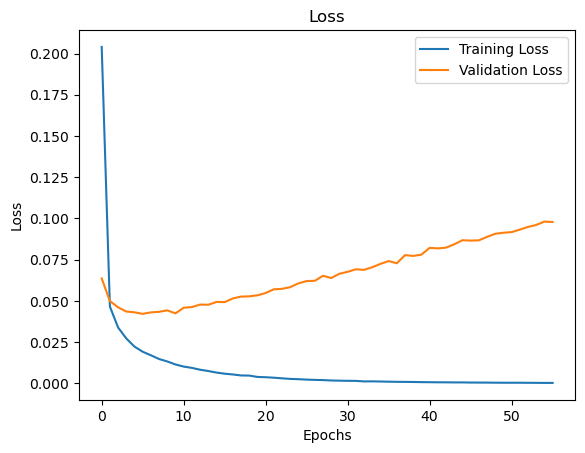

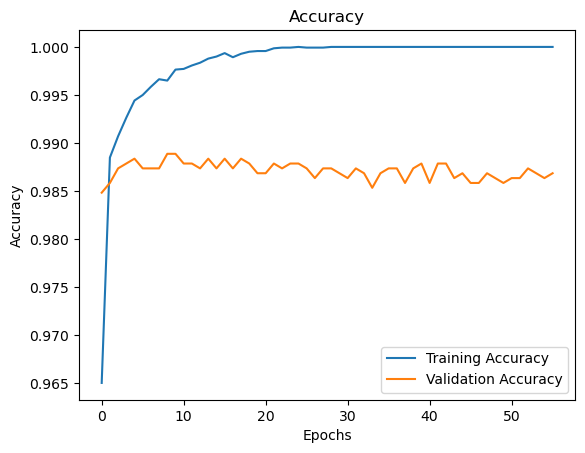

In [18]:
def plot_training_history(history):
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_accuracy = history['train_accuracy']
    val_accuracy = history['val_accuracy']
    epochs = range(len(train_loss))

    # Move tensors from CUDA device to CPU if they are tensors
    if isinstance(train_accuracy[0], torch.Tensor):
        train_accuracy = [acc.cpu() for acc in train_accuracy]
    if isinstance(val_accuracy[0], torch.Tensor):
        val_accuracy = [acc.cpu() for acc in val_accuracy]

    # Plot loss
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)


In [22]:
# Lấy danh sách các lớp từ tập dữ liệu train (hoặc bất kỳ tập dữ liệu nào khác trong dataset1)
all_classes = dataset1['train'].dataset.classes

# In ra danh sách các lớp
print("Danh sách các lớp:", all_classes)

Danh sách các lớp: ['Organic', 'Recycle', 'UnRecycle']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

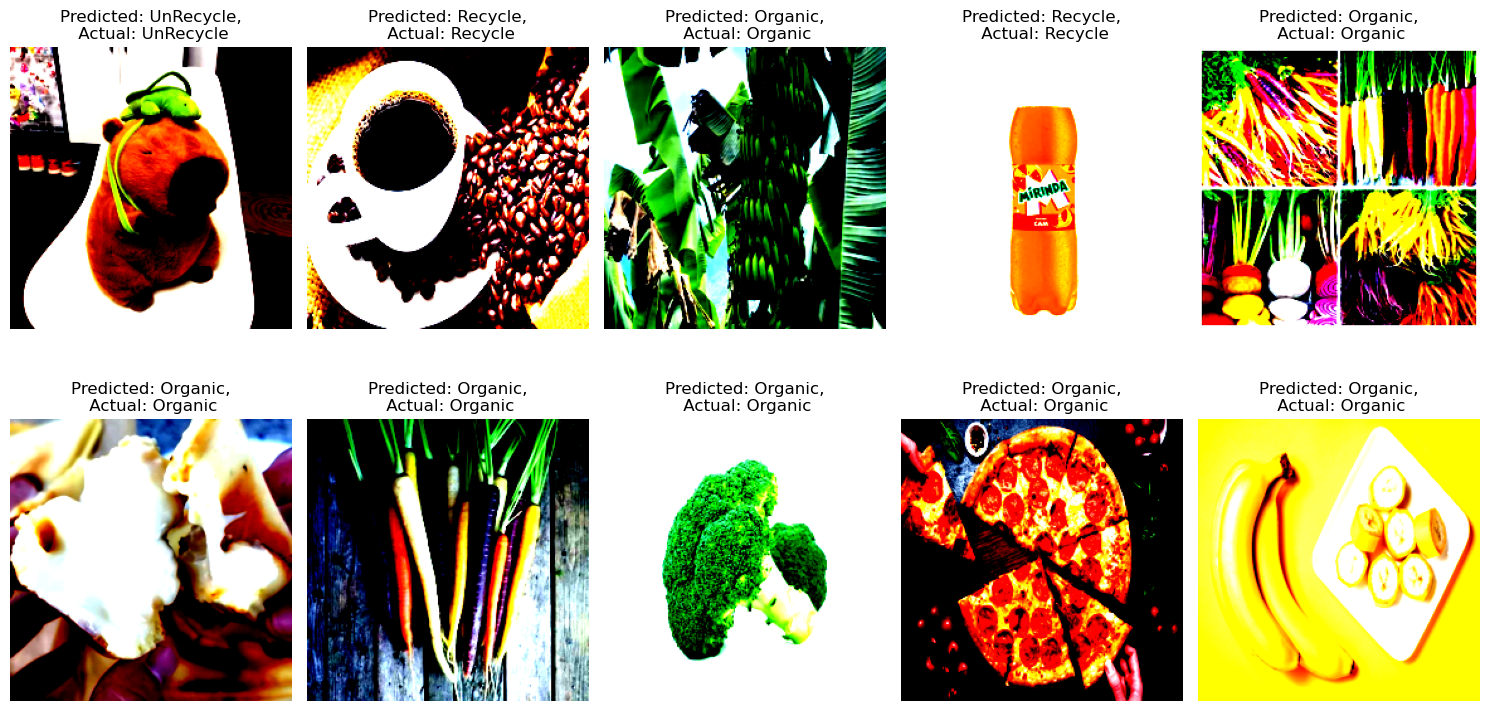

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Chuyển mô hình sang chế độ đánh giá (evaluation mode)
model.eval()

# Lấy tên các lớp từ tập dữ liệu
class_names = all_classes

# Lấy 10 ảnh và nhãn tương ứng từ tập dữ liệu test
num_images_to_display = 10
images_to_display = []
labels_to_display = []

for images, labels in dataloaders['test']:
    for i in range(len(labels)):
        images_to_display.append(images[i])
        labels_to_display.append(labels[i].item())
    if len(images_to_display) >= num_images_to_display:
        break

# Dự đoán và hiển thị 10 ảnh cùng với dự đoán và tên lớp
with torch.no_grad():
    plt.figure(figsize=(15, 8))
    for i in range(num_images_to_display):
        image = images_to_display[i].unsqueeze(0).to(device)  # Thêm chiều batch và chuyển đến device
        label = labels_to_display[i]
        
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()

        # Hiển thị ảnh và dự đoán
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images_to_display[i], (1, 2, 0)))
        plt.title(f'Predicted: {class_names[predicted_label]},\n Actual: {class_names[label]}')
        plt.axis('off')

plt.tight_layout()
plt.show()


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


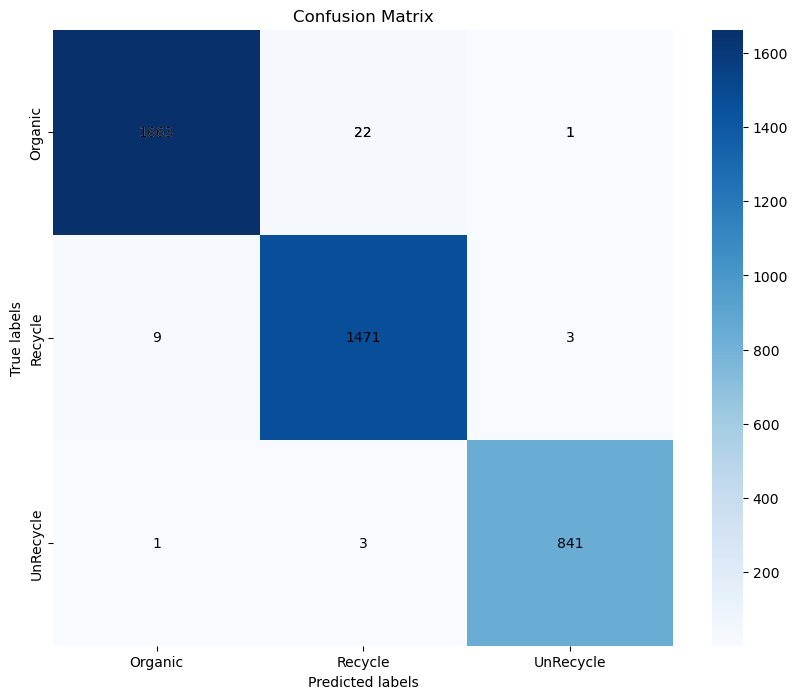

In [24]:
# Chuyển mô hình sang chế độ đánh giá (evaluation mode)
model.eval()

# Tạo danh sách dự đoán và nhãn thực tế
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.tolist())  # Chuyển tensor sang danh sách Python
        all_labels.extend(labels.tolist())  # Chuyển tensor sang danh sách Python

# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Vẽ ma trận nhầm lẫn với số toàn bộ trên mỗi ô
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Ghi đè số trên từng ô
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        plt.text(j + 0.5, i + 0.5, conf_matrix[i][j], ha='center', va='center', color='black')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [25]:
report = classification_report(all_labels, all_predictions, target_names=class_names, output_dict=True)
df = pd.DataFrame(report).transpose()
df


,precision,recall,f1-score,support
Organic,0.994023,0.986358,0.990176,1686.000000
Recycle,0.983289,0.991908,0.987580,1483.000000
UnRecycle,0.995266,0.995266,0.995266,845.000000
accuracy,0.990284,0.990284,0.990284,0.990284
macro avg,0.990859,0.991178,0.991007,4014.000000
weighted avg,0.990319,0.990284,0.990288,4014.000000


In [26]:
print("Thời gian huấn luyện model là:", execution_time, "s")

Thời gian huấn luyện model là: 17758.569538593292 s
